Notebook utilizzato per la selezione dei parametri da utilizzare nel bdt. Si utilizza una grid search seguita da cross validation

In [1]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import xgboost as xgb
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
import pickle

## Data preliminary

Setting weigths for background, plotting distributions and correlations of features

In [2]:
%run analysis_utils.py


In [3]:
df_ML=pd.read_pickle('df_ML.pkl')

In [4]:
bkg=df_ML.query('y==0')
sig=df_ML.query('y==1')

In [5]:
df_ML

,V0pt,TPCnSigmaHe3,DistOverP,InvMass,ArmenterosAlpha,V0CosPA,V0Chi2,PiProngPt,He3ProngPt,ProngsDCA,He3ProngPvDCA,PiProngPvDCA,NpidClustersHe3,TPCnSigmaPi,Lrec,y
0,1.801913,0.500,3.079487,2.992206,0.848579,0.997848,0.0,0.194784,1.619431,0.77,1.000000,1.000,120.0,0.125,6.497778,1
1,2.850354,0.625,5.009816,2.992606,-0.865971,0.999918,0.0,0.193109,2.667301,0.58,0.667969,1.000,124.0,1.125,14.319689,1
2,3.941775,-0.500,2.213483,2.993389,0.799560,0.999990,0.0,0.408496,3.537629,0.00,0.156250,1.000,127.0,-1.000,9.055533,1
3,5.601911,0.250,3.571688,2.992445,-0.892057,0.999999,0.0,0.276571,5.337098,0.40,0.519531,1.000,145.0,-0.375,22.357100,1
4,2.040387,0.625,6.642829,2.986990,-0.794670,0.999532,0.0,0.215732,1.830621,0.68,0.910156,1.000,87.0,-0.375,13.555475,1
5,3.432498,-2.000,3.757954,2.994277,-0.876915,0.997813,0.0,0.245561,3.211884,0.39,1.000000,1.000,114.0,1.000,13.172921,1
6,2.269736,0.500,2.579412,2.987460,-0.806079,0.999986,0.0,0.245714,2.032371,0.01,0.257812,1.000,124.0,0.125,6.225307,1
7,7.503637,-0.625,1.469103,2.993088,0.858113,0.999996,0.0,0.532635,6.979688,0.00,0.179688,1.000,72.0,-0.625,11.105997,1
8,4.923028,-0.500,16.711594,2.994217,0.859516,0.999945,0.0,0.412371,4.510935,0.32,1.000000,1.000,145.0,0.000,101.125900,1
9,2.572411,1.625,1.313258,2.992268,0.875655,0.999982,0.0,0.200536,2.408338,0.02,0.156250,1.000,111.0,-0.375,3.489885,1


In [6]:
data=pd.concat([bkg,sig],ignore_index=True)
data=data.sample(frac=1)

In [7]:
training_columns=[ 'V0CosPA','ProngsDCA', 'DistOverP', 'ArmenterosAlpha','NpidClustersHe3','V0pt','TPCnSigmaHe3']

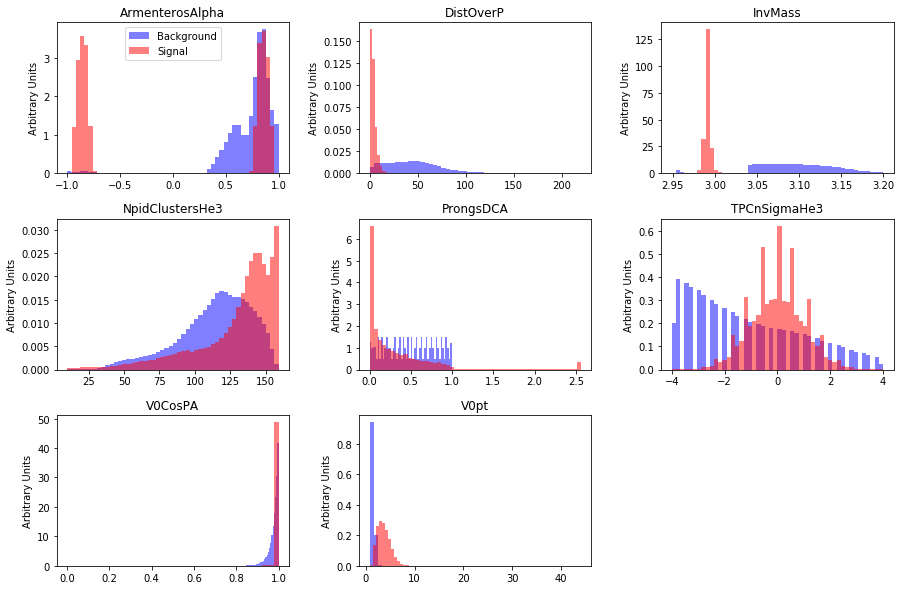

In [8]:
plot_distr(data,training_columns+['InvMass'])

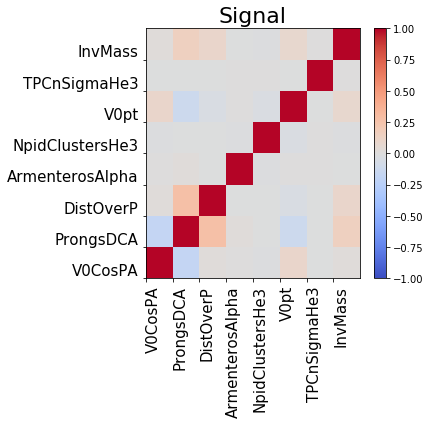

In [9]:
plot_corr(data,training_columns+['InvMass'],"Signal")

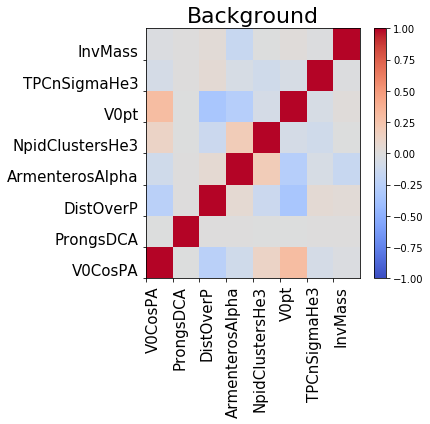

In [10]:
plot_corr(data,training_columns+['InvMass'],"Background")

In [11]:
y_target=data["y"]

In [12]:
data=data.drop(["y"],axis=1)

In [13]:
traindata,testdata,ytrain,ytest= train_test_split(data, y_target, test_size=0.5, random_state=42)

## Parameters Optimization

Transforming in xgb Matrix. Optimization with cross validation,tuning of parameters, and final training

In [14]:
dtrain = xgb.DMatrix(data=traindata[training_columns], label=ytrain, feature_names=training_columns, silent=True)

/home/fmazzasc/.local/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


In [15]:
dtest = xgb.DMatrix(data=testdata[training_columns], label=ytest, feature_names=training_columns, silent=True)

In [16]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=23)
scoring = 'auc'
early_stopping_rounds = 20
num_rounds = 200
params = {
    # Parameters that we are going to tune.
    'max_depth':8,
    'eta':0.05,
    'gamma':0.7,
    'min_child_weight':8,
    'subsample':0.8,
    'colsample_bytree':0.9,
    'objective':'binary:logistic',
    'random_state':42,
    'silent':1,
    'nthread':4,
    'tree_method':'hist'}

In [ ]:
def optimize_params(dtrain,par):
    %run analysis_utils.py
    gs_dict = {'first_par': {'name': 'max_depth', 'par_values': [i for i in range(2, 10, 2)]},
           'second_par': {'name': 'min_child_weight', 'par_values':[i for i in range(0, 12, 2)]},
          }
    par['max_depth'],par['min_child_weight'],_ = gs_2par(gs_dict, par, dtrain, num_rounds, 42, cv, scoring, early_stopping_rounds)
    
    gs_dict = {'first_par': {'name': 'subsample', 'par_values': [i/10. for i in range(4, 10)]},
           'second_par': {'name': 'colsample_bytree', 'par_values': [i/10. for i in range(8, 10)]},
          }
    par['subsample'],par['colsample_bytree'],_ = gs_2par(gs_dict, par, dtrain, num_rounds, 42, cv, scoring, early_stopping_rounds)
    gs_dict = {'first_par': {'name': 'gamma', 'par_values': [i/10. for i in range(0, 11)]}} 
    par['gamma'],_ = gs_1par(gs_dict, par, dtrain, num_rounds, 42, cv, scoring, early_stopping_rounds)
    gs_dict = {'first_par': {'name': 'eta', 'par_values': [0.1, 0.05, 0.01, 0.005, 0.001]}}
    par['eta'],n = gs_1par(gs_dict, par, dtrain, num_rounds, 42, cv, scoring, early_stopping_rounds)
    return n

In [ ]:
%time
nround = optimize_params(dtrain,params)

In [ ]:
early_stopping_rounds

In [17]:
best_model = xgb.train(params, dtrain,num_boost_round=num_rounds)

In [ ]:
gs_dict = {'first_par': {'name': 'max_depth', 'par_values': [i for i in range(7, 10, 1)]},
           'second_par': {'name': 'min_child_weight', 'par_values':[i for i in range(7, 10, 1)]},
          }
params['max_depth'],params['min_child_weight'],_ = gs_2par(gs_dict, params, dtrain, num_rounds, 42, cv, scoring, early_stopping_rounds)
    

In [17]:
best_model = xgb.train(params, dtrain,num_boost_round=num_rounds)

## Test

Roc curve, feature importance, output of the model and distributions of the features with different cuts on bdt score

ROC_AUC test set: 0.999940


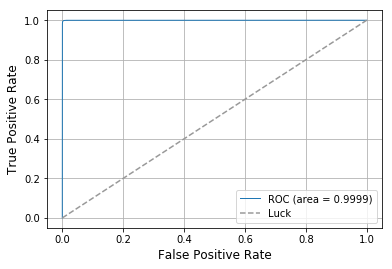

In [18]:
y_pred= best_model.predict(dtest,output_margin=True)
print(f"ROC_AUC test set: {roc_auc_score(ytest, y_pred):.6f}")
plot_roc(ytest, y_pred)

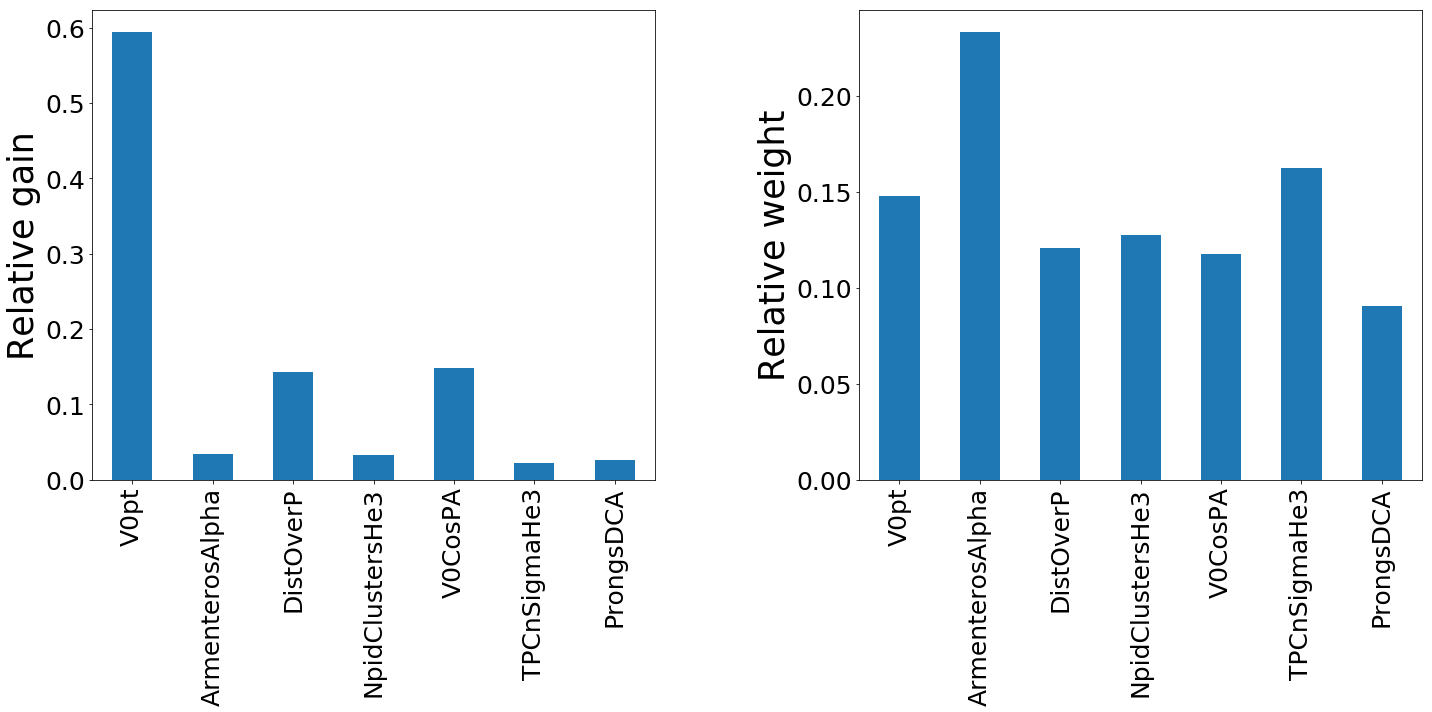

In [19]:
plot_feature_imp(best_model,['gain','weight'])

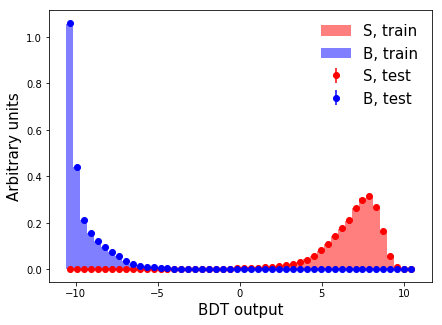

In [20]:
plot_output_train_test(best_model, traindata[training_columns], ytrain, testdata[training_columns], ytest, branch_names=training_columns,raw=True)

In [21]:
testdata['Score']=y_pred

/home/fmazzasc/.local/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [22]:
testdata['y']=ytest

/home/fmazzasc/.local/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


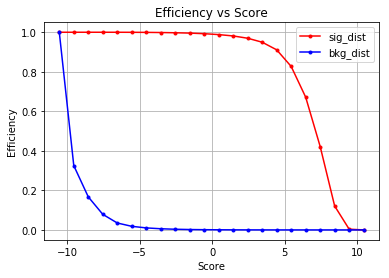

In [23]:
EfficiencyVsCuts(testdata)

## Test on lhc18r ( 2.96<InvMass<3.04)

In [24]:
df_18r=pd.read_pickle('df_Sig_data.pkl')

In [25]:
len(df_18r)

11525633

In [26]:
d_18r = xgb.DMatrix(data=df_18r[training_columns], feature_names=training_columns, silent=True)

In [27]:
score_18r= best_model.predict(d_18r,output_margin=True)

In [28]:
df_18r['Score']=score_18r

In [3]:
df_cut=df_18r.query('Score>6')

NameError: name 'df_18r' is not defined

In [4]:
n,bins,_=plt.hist(df_cut['InvMass'],bins=50,range=[2.95,3.05],histtype='barstacked');

NameError: name 'plt' is not defined

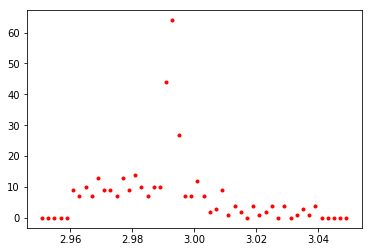

In [31]:
bin_centers = 0.5*(bins[1:]+bins[:-1])
plt.plot(bin_centers,n,'r.');

In [33]:
df_18r.to_pickle('df_18r.pkl')